In [ ]:
!gdown "https://drive.google.com/u/0/uc?id=1IHdxHKthYDHcN_zx9Pxon2qKCtpdb2ni&export=download"

Downloading...
From: https://drive.google.com/u/0/uc?id=1IHdxHKthYDHcN_zx9Pxon2qKCtpdb2ni&export=download
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 75.1MB/s]


In [ ]:
!unzip "/content/Aloe_images.zip"

Archive:  /content/Aloe_images.zip
  inflating: Aloe/Aloe_left_1.png    
  inflating: Aloe/Aloe_right_3.png   
  inflating: Aloe/Aloe_right_1.png   
  inflating: Aloe/Aloe_right_2.png   
  inflating: Aloe/Disparity_map_corr.png  


In [ ]:
import cv2
import time
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
import numpy as np
disparity_range = 64
kernel_size = 10

# Pixel-wise Matching
- L1, L2 norms
<br>
- Non-vectorized and Vectoried


## Function

### Non - Vectoried

In [ ]:
# function find disparity map with pixel-wise matching non vectorized
def pixel_wise_matching_nonvectorize(left_img_path, right_img_path, disparity_range = 16, compute_type = "L1", save_result = True):
  print("Compute disparity map using pixel-wise matching with", compute_type)
  # read grascale left and right imgage with opencv, change it to numpy array with dytpe = float32
  left_img = cv2.imread(left_img_path, 0)
  right_img = cv2.imread(right_img_path, 0)
  left_img = np.asarray(left_img, dtype = np.float32)
  right_img = np.asarray(right_img, dtype = np.float32)
  
  # get height and width of left image
  left_height, left_width = left_img.shape

  # create depth zeros matrix (height, width)
  depth = np.zeros((left_height, left_width)).astype(np.uint8)
  
  if compute_type == "L1":
    max_cost = 255
  elif compute_type == "L2":
    max_cost = 255 ** 2

  # some variable
  d_optimal = 0

  # for each pixel
  for y in tqdm(range(left_height)):
    for x in range(left_width):
      # in disparity range
      if compute_type == "L1":
        min_cost = max_cost if (x - disparity_range < 0) else abs(left_img[y, x] - right_img[y, x - disparity_range])
      elif compute_type == "L2":
        min_cost = max_cost if (x - disparity_range < 0) else (left_img[y, x] - right_img[y, x - disparity_range]) ** 2
      for d in range(disparity_range):
        # calculate the cost
        if compute_type == "L1":
          cost = max_cost if (x - d < 0) else abs(left_img[y, x] - right_img[y, x - d])
        elif compute_type == "L2":
          cost = max_cost if (x - d < 0) else (left_img[y, x] - right_img[y, x - d]) ** 2

        # find d_optimal
        if cost < min_cost:
          min_cost = cost
          d_optimal = d

      depth[y, x] = d_optimal * (255 / disparity_range)
  
  # save the result
  if save_result:
    cv2.imwrite("Disparity_grascale.png", depth)
    cv2.imwrite("Disparity_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
    print("Saving result ...")

  print("Done")
  return depth

### Vectoried

In [ ]:
# function find disparity map with pixel-wise matching vectorized
def pixel_wise_matching_vectorize(left_img_path, right_img_path, disparity_range = 16, compute_type = "L1", save_result = True):
  print("Compute disparity map using pixel-wise matching vectorization way with", compute_type)
  # read grascale left and right imgage with opencv, change it to numpy array with dytpe = float32
  left_img = cv2.imread(left_img_path, 0)
  right_img = cv2.imread(right_img_path, 0)
  left_img = np.asarray(left_img, dtype = np.float32)
  right_img = np.asarray(right_img, dtype = np.float32)
  # get height and width of left image
  left_height, left_width = left_img.shape
  
  cost_space_l1 = np.full((left_height, left_width, disparity_range), 255, dtype = np.float32)
  cost_space_l2 = np.full((left_height, left_width, disparity_range), 255 ** 2, dtype = np.float32)

  for d in tqdm(range(disparity_range)):
    left_d = left_img[:, d: left_width]
    right_d = right_img[:, 0: left_width - d]
    if compute_type == "L1":
      cost_space_l1[:, d : left_width, d] = np.abs(left_d - right_d)
    elif compute_type == "L2":
      cost_space_l2[:, d : left_width, d] = (left_d - right_d) ** 2

  if compute_type == "L1":
    cost_space = cost_space_l1
  elif compute_type == "L2":
    cost_space = cost_space_l2

  depth = np.argmin(cost_space, axis=2) * (255 / disparity_range)
  depth = depth.astype(np.uint8)
  # save the result
  if save_result:
    cv2.imwrite("Disparity_grascale.png", depth)
    cv2.imwrite("Disparity_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
    print("Saving result ...")

  print("Done")
  return depth

## Test with L1 Pixel-wise matching non-vectorized

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# disparity_range = 64, compute_type = L1
pixel_wise_result = pixel_wise_matching_nonvectorize(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", save_result = True)

Compute disparity map using pixel-wise matching with L1


  0%|          | 0/370 [00:00<?, ?it/s]

Saving result ...
Done


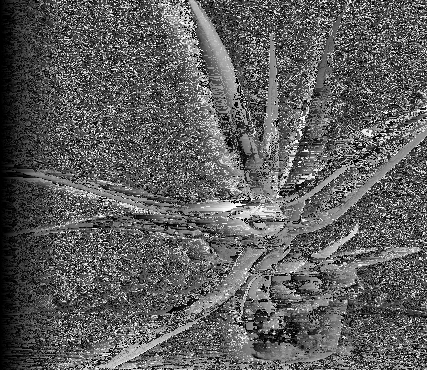

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

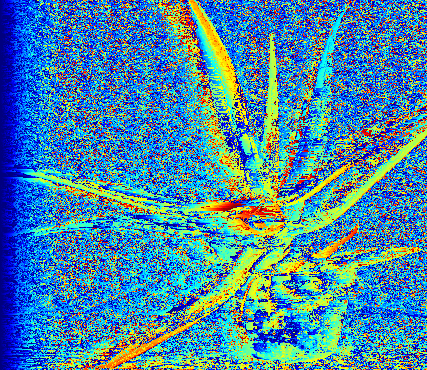

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Test with L1 Pixel-wise matching vectoried

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# disparity_range = 64, compute_type = L1
pixel_wise_result = pixel_wise_matching_vectorize(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", save_result = True)

Compute disparity map using pixel-wise matching vectorization way with L1


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done


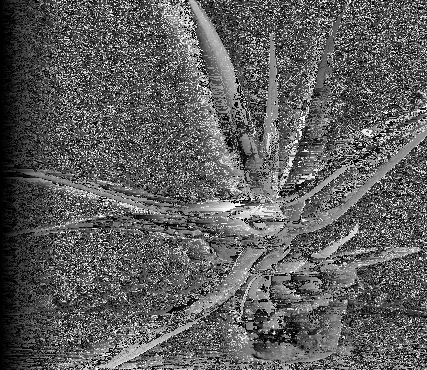

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

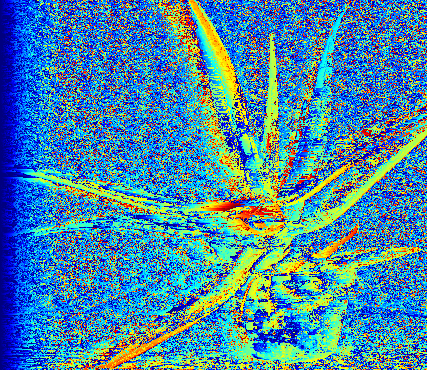

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Compare time between 2 fundtion vectoried and non-vectoried in L1 norm

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# non-vectoried
start_time = time.clock()
pixel_wise_result = pixel_wise_matching_nonvectorize(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", save_result = True)
end_time = time.clock()
time_nonvectorize = end_time - start_time

# vectoried
start_time = time.clock()
pixel_wise_result = pixel_wise_matching_vectorize(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", save_result = True)
end_time = time.clock()
time_vectorize = end_time - start_time

print("-----------****-----------")
print("Non-vectorize function:", time_nonvectorize, "seconds")
print("Vectorize function:", time_vectorize, "seconds")


Compute disparity map using pixel-wise matching with L1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


  0%|          | 0/370 [00:00<?, ?it/s]

Saving result ...
Done
Compute disparity map using pixel-wise matching vectorization way with L1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done
-----------****-----------
Non-vectorize function: 9.16109200000001 seconds
Vectorize function: 0.3604700000000065 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


## Test with L2 Pixel-wise matching non-vectoried

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# disparity_range = 64, compute_type = L2
pixel_wise_result = pixel_wise_matching_nonvectorize(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", save_result = True)

Compute disparity map using pixel-wise matching with L2


  0%|          | 0/370 [00:00<?, ?it/s]

Saving result ...
Done


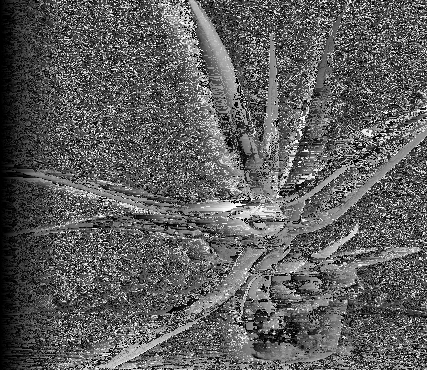

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

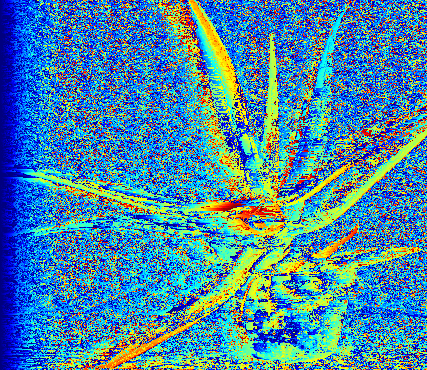

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Test with L2 Pixel-wise matching vectoried

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# disparity_range = 16, compute_type = L2
pixel_wise_result = pixel_wise_matching_vectorize(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", save_result = True)

Compute disparity map using pixel-wise matching vectorization way with L2


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done


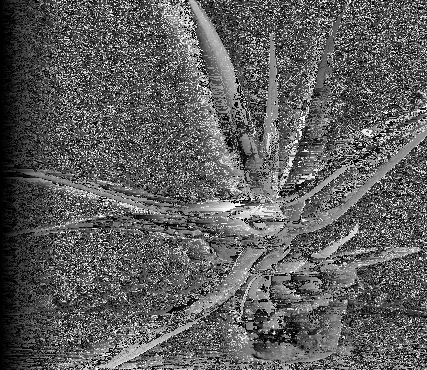

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

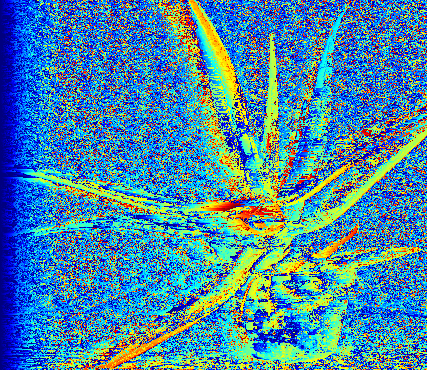

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Compare time between 2 fundtion vectoried and non-vectoried in L2 norm

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# non-vectoried
start_time = time.clock()
pixel_wise_result = pixel_wise_matching_nonvectorize(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", save_result = True)
end_time = time.clock()
time_nonvectorize = end_time - start_time

#vectoried
start_time = time.clock()
pixel_wise_result = pixel_wise_matching_vectorize(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", save_result = True)
end_time = time.clock()
time_vectorize = end_time - start_time

print("-----------****-----------")
print("Non-vectorize function:", time_nonvectorize, "seconds")
print("Vectorize function:", time_vectorize, "seconds")


Compute disparity map using pixel-wise matching with L2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


  0%|          | 0/370 [00:00<?, ?it/s]

Saving result ...
Done
Compute disparity map using pixel-wise matching vectorization way with L2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done
-----------****-----------
Non-vectorize function: 42.411704000000015 seconds
Vectorize function: 0.336685000000017 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


# Window-based Matching

## Function

### Non - Vectoried

In [ ]:
# function find disparity map with pixel-wise matching non vectorized
def window_based_matching_nonvectoried(left_img_path, right_img_path, disparity_range = 16, compute_type = "L1", kernel_size = 5, save_result = True):
  print("Compute disparity map using window_based matching with", compute_type)

  # read grascale left and right imgage with opencv, change it to numpy array with dytpe = float32
  left_img = cv2.imread(left_img_path, 0)
  right_img = cv2.imread(right_img_path, 0)
  left_img = np.asarray(left_img, dtype = np.float32)
  right_img = np.asarray(right_img, dtype = np.float32)
  # get height and width of left image
  left_height, left_width = left_img.shape

  # create depth zeros matrix (height, width)
  depth = np.zeros((left_height, left_width)).astype(np.uint8)

  if compute_type == "L1":
    max_cost = 255
  elif compute_type == "L2":
    max_cost = 255 ** 2

  # some variable
  d_optimal = 0
  kernel_half = int((kernel_size - 1) / 2)
  
  # for each pixel
  for y in tqdm(range(kernel_half, left_height - kernel_half)):
    for x in range(kernel_half, left_width - kernel_half):
      # in disparity range
      if compute_type == "L1":
        min_cost = max_cost if (x - kernel_half - disparity_range < 0) or (x + kernel_half - disparity_range + 1 < 0) else np.sum(np.abs(left_img[y - kernel_half : y + kernel_half + 1, x - kernel_half : x + kernel_half + 1] - right_img[y - kernel_half : y + kernel_half + 1, x - kernel_half - disparity_range : x + kernel_half - disparity_range + 1]))
      elif compute_type == "L2":
        min_cost = max_cost if (x - kernel_half - disparity_range < 0) or (x + kernel_half - disparity_range + 1 < 0) else np.sum((left_img[y - kernel_half : y + kernel_half + 1, x - kernel_half : x + kernel_half + 1] - right_img[y - kernel_half : y + kernel_half + 1, x - kernel_half - disparity_range : x + kernel_half - disparity_range + 1]) ** 2)
      
      for d in range(disparity_range):
        # calculate the cost
        if compute_type == "L1":
          cost = max_cost if (x - kernel_half - d < 0) or (x + kernel_half - d + 1 < 0) else np.sum(np.abs(left_img[y - kernel_half : y + kernel_half + 1, x - kernel_half : x + kernel_half + 1] - right_img[y - kernel_half : y + kernel_half + 1, x - kernel_half - d : x + kernel_half - d + 1]))
        elif compute_type == "L2":
          cost = max_cost if (x - kernel_half - d < 0) or (x + kernel_half - d + 1 < 0) else np.sum((left_img[y - kernel_half : y + kernel_half + 1, x - kernel_half : x + kernel_half + 1] - right_img[y - kernel_half : y + kernel_half + 1, x - kernel_half - d : x + kernel_half - d + 1]) ** 2)

        # find d_optimal
        if cost < min_cost:
          min_cost = cost
          d_optimal = d

      depth[y, x] = d_optimal * (255 / disparity_range)
  
  # save the result
  if save_result:
    cv2.imwrite("Disparity_grascale.png", depth)
    cv2.imwrite("Disparity_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
    print("Saving result ...")

  print("Done")
  return depth

### Vectoried

In [ ]:
def compute_intergral_image(img):
  sum_axis_0 = np.cumsum(img, axis = 0)
  sum_axis_1 = np.cumsum(sum_axis_0, axis = 1)
  return sum_axis_1

In [ ]:
# function find disparity map with pixel-wise matching vectorized
def window_based_matching_vectoried(left_img_path, right_img_path, disparity_range = 16, compute_type = "L1", kernel_size = 5, save_result = True):
  print("Compute disparity map using window_based matching with", compute_type)

  # read grascale left and right imgage with opencv, change it to numpy array with dytpe = float32
  left_img = cv2.imread(left_img_path, 0)
  right_img = cv2.imread(right_img_path, 0)
  left_img = np.asarray(left_img, dtype = np.float32)
  right_img = np.asarray(right_img, dtype = np.float32)
  # get height and width of left image
  left_height, left_width = left_img.shape

  # some variable
  kernel_half = int((kernel_size - 1) / 2)

  cost_space_l1 = np.full((left_height, left_width, disparity_range), 255, dtype = np.float32)
  cost_space_l2 = np.full((left_height, left_width, disparity_range), 255 ** 2, dtype = np.float32)

  # find cost space
  for d in tqdm(range(disparity_range)):
    left_d = left_img[:, d: left_width]
    right_d = right_img[:, 0: left_width - d]
    if compute_type == "L1":
      cost_space_l1[:, d : left_width, d] = np.abs(left_d - right_d)
    elif compute_type == "L2":
      cost_space_l2[:, d : left_width, d] = (left_d - right_d) ** 2

  if compute_type == "L1":
    cost_space = cost_space_l1
  elif compute_type == "L2":
    cost_space = cost_space_l2

  # find integral from cost space
  integral = np.full((left_height, left_width, disparity_range), 255, dtype = np.float32)
  for d in range(disparity_range):
    integral[:, :, d] = compute_intergral_image(cost_space[:, :, d])
  
  # compute sum of window with kernel size
  cost_space_compute_sum = np.full((left_height, left_width, disparity_range), 255, dtype = np.float32)

  cost_space_compute_sum[: left_height - kernel_half , : left_width - kernel_half , :] = integral[kernel_half :, kernel_half :, :]
  cost_space_compute_sum[kernel_half +1:, kernel_half +1:, :] += integral[: left_height - kernel_half -1, : left_width - kernel_half -1, :]
  cost_space_compute_sum[kernel_half +1:, : left_width - kernel_half , :] -= integral[: left_height - kernel_half -1, kernel_half :, :]
  cost_space_compute_sum[: left_height - kernel_half , kernel_half +1:, :] -= integral[kernel_half :, : left_width - kernel_half -1, :]

  depth = np.argmin(cost_space_compute_sum, axis=2) * (255 / disparity_range)
  depth = depth.astype(np.uint8)

  # save the result
  if save_result:
    cv2.imwrite("Disparity_grascale.png", depth)
    cv2.imwrite("Disparity_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
    print("Saving result ...")

  print("Done")
  return depth

## Test with L1 Window-based matching non-vectorized

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# disparity_range = 64, kernel_size = 10, compute_type = L1
window_based_result = window_based_matching_nonvectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", kernel_size = kernel_size, save_result = True)

Compute disparity map using window_based matching with L1


  0%|          | 0/362 [00:00<?, ?it/s]

Saving result ...
Done


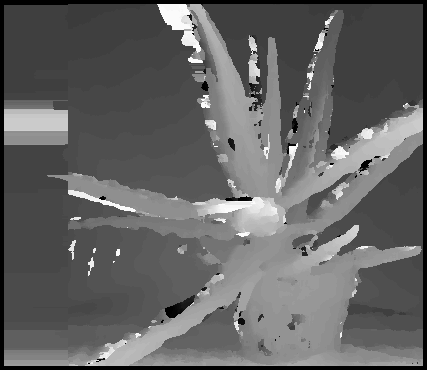

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

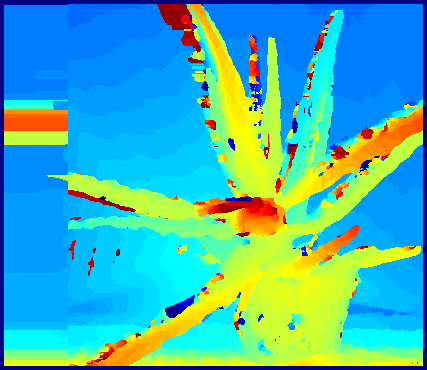

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Test with L1 Window-based matching vectorized

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# disparity_range = 64, kernel_size = 10, compute_type = L1
window_based_result = window_based_matching_vectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", kernel_size = kernel_size, save_result = True)

Compute disparity map using window_based matching with L1


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done


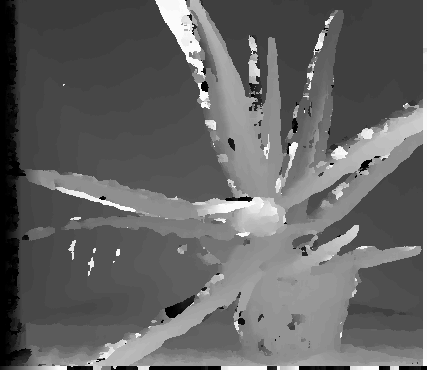

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

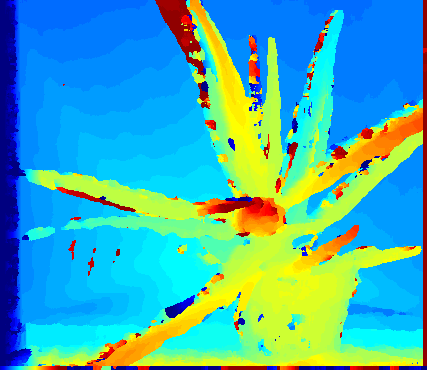

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Compare time between 2 fundtion vectoried and non-vectoried in L1 norm

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# non-vectoried
start_time = time.clock()
window_based_result = window_based_matching_nonvectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", kernel_size = kernel_size, save_result = True)
end_time = time.clock()
time_nonvectorize = end_time - start_time

# vectoried
start_time = time.clock()
window_based_result = window_based_matching_vectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", kernel_size = kernel_size, save_result = True)
end_time = time.clock()
time_vectorize = end_time - start_time

print("Non-vectorize function", time_nonvectorize, "seconds")
print("vectorize function", time_vectorize, "seconds")


Compute disparity map using window_based matching with L1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


  0%|          | 0/362 [00:00<?, ?it/s]

Saving result ...
Done
Compute disparity map using window_based matching with L1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/16 [00:00<?, ?it/s]

Saving result ...
Done
Non-vectorize function 24.572985000000017 seconds
vectorize function 0.22201899999993202 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


## Test with L2 Pixel-wise matching non-vectorized

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# disparity_range = 64, kernel_size = 10, compute_type = L2
window_based_result = window_based_matching_nonvectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", kernel_size = kernel_size, save_result = True)

Compute disparity map using window_based matching with L2


  0%|          | 0/362 [00:00<?, ?it/s]

Saving result ...
Done


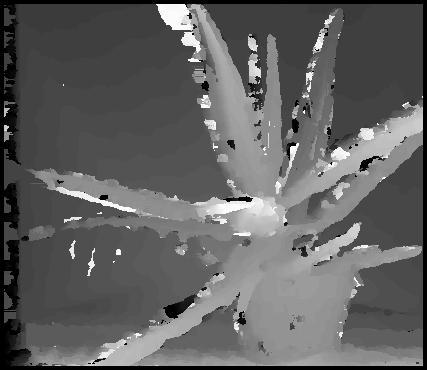

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

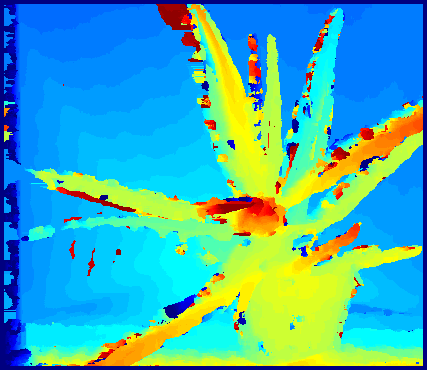

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Test with L2 Pixel-wise matching vectorized

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# disparity_range = 16, kernel_size = 5, compute_type = L2
window_based_result = window_based_matching_vectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", kernel_size = kernel_size, save_result = True)

Compute disparity map using window_based matching with L2


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done


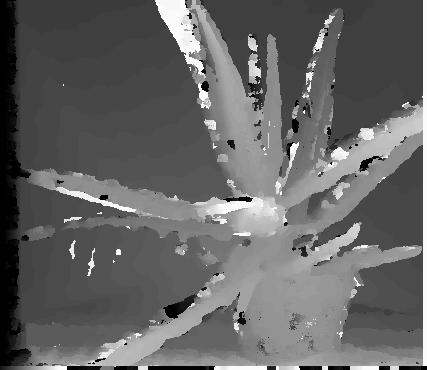

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

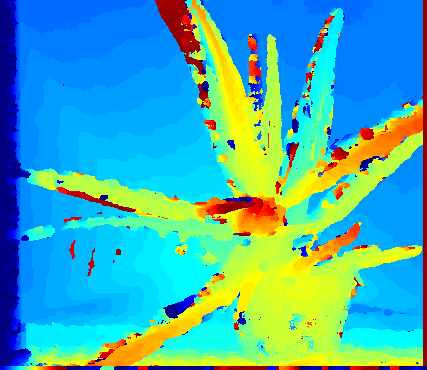

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Compare time between 2 fundtion vectoried and non-vectoried in L2 norm

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_1.png"

# non-vectoried
start_time = time.clock()
window_based_result = window_based_matching_nonvectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", kernel_size = kernel_size, save_result = True)
end_time = time.clock()
time_nonvectorize = end_time - start_time

# vectoried
start_time = time.clock()
window_based_result = window_based_matching_vectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", kernel_size = kernel_size, save_result = True)
end_time = time.clock()
time_vectorize = end_time - start_time

print("Non-vectorize function: ", time_nonvectorize, "seconds")
print("vectorize function: ", time_vectorize, "seconds")


Compute disparity map using window_based matching with L2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


  0%|          | 0/362 [00:00<?, ?it/s]

Saving result ...
Done
Compute disparity map using window_based matching with L2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done
Non-vectorize function:  92.38472300000012 seconds
vectorize function:  0.7947320000000673 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


# Test with 2 image with difference of brightness by Window-base method (L1 and L2 norm) 


## Test with L1 vectoried function

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_2.png"

# disparity_range = 64, compute_type = "L1", kernel_size = 5
window_based_result = window_based_matching_vectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L1", kernel_size = kernel_size, save_result = True)

Compute disparity map using window_based matching with L1


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done


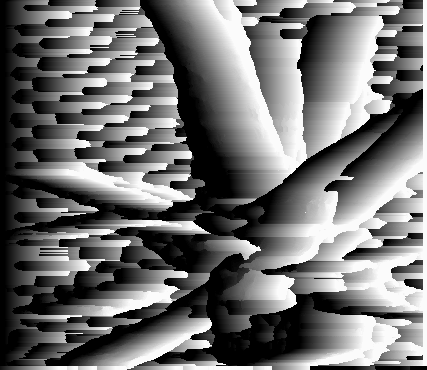

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

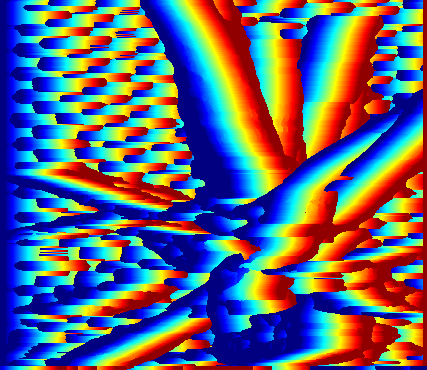

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

## Test with L2 vectoried function

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_2.png"

# disparity_range = 64, compute_type = "L2", kernel_size = 10
window_based_result = window_based_matching_vectoried(left_img_path, right_img_path, disparity_range = disparity_range, compute_type = "L2", kernel_size = kernel_size, save_result = True)

Compute disparity map using window_based matching with L2


  0%|          | 0/64 [00:00<?, ?it/s]

Saving result ...
Done


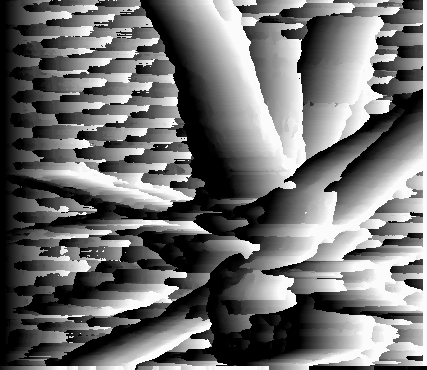

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

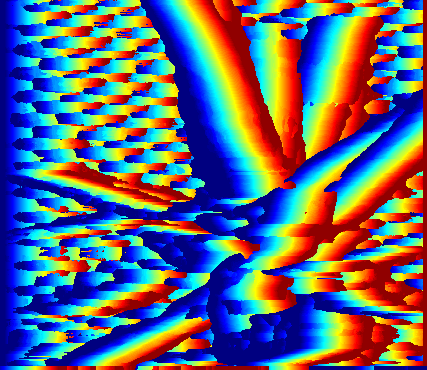

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

# Solve the problem of 2 image with diference of brightness by Window-based medthod(Consine similarity)

## Vectoried Function

In [ ]:
def compute_intergral_image(img):
  sum_axis_0 = np.cumsum(img, axis = 0)
  sum_axis_1 = np.cumsum(sum_axis_0, axis = 1)
  return sum_axis_1

In [ ]:
# function find disparity map with window-based matching vectorized
def window_based_matching_cosine_similarity_vectoried(left_img_path, right_img_path, disparity_range = 16, compute_type = "L1", kernel_size = 5, save_result = True):
  print("Compute disparity map using window_based matching with", compute_type)

  # read grascale left and right imgage with opencv, change it to numpy array with dytpe = float32
  left_img = cv2.imread(left_img_path, 0)
  right_img = cv2.imread(right_img_path, 0)
  left_img = np.asarray(left_img, dtype = np.float32)
  right_img = np.asarray(right_img, dtype = np.float32)
  # get height and width of left image
  left_height, left_width = left_img.shape

  # some variable
  kernel_half = int((kernel_size - 1) / 2)


  # find integral X^2 and Y^2 from left and right image
  integral_xx = compute_intergral_image(left_img*left_img)
  integral_yy = compute_intergral_image(right_img*right_img)

  # find integral XY from left and right image
  integral_xy = np.full((left_height, left_width, disparity_range), 255, dtype = np.float32)
  for d in range(disparity_range):
    integral_xy[:, d : left_width, d] = left_img[:, d : left_width] * right_img[:, 0 : left_width - d]
    integral_xy[:, :, d] = compute_intergral_image(integral_xy[:, :, d])

  # compute sum of window
  integral_sum_xy = np.full((left_height, left_width, disparity_range), 255, dtype = np.float32)
  integral_sum_xx = np.full((left_height, left_width), 255, dtype = np.float32)
  integral_sum_yy = np.full((left_height, left_width), 255, dtype = np.float32)

  integral_sum_xy[: left_height - kernel_half , : left_width - kernel_half , :] = integral_xy[kernel_half :, kernel_half :, :]
  integral_sum_xy[kernel_half +1:, kernel_half +1:, :] += integral_xy[: left_height - kernel_half -1, : left_width - kernel_half -1, :]
  integral_sum_xy[kernel_half +1:, : left_width - kernel_half , :] -= integral_xy[: left_height - kernel_half -1, kernel_half :, :]
  integral_sum_xy[: left_height - kernel_half , kernel_half +1:, :] -= integral_xy[kernel_half :, : left_width - kernel_half -1, :]

  integral_sum_xx[: left_height - kernel_half , : left_width - kernel_half] = integral_xx[kernel_half :, kernel_half :]
  integral_sum_xx[kernel_half +1:, kernel_half +1:] += integral_xx[: left_height - kernel_half -1, : left_width - kernel_half -1]
  integral_sum_xx[kernel_half +1:, : left_width - kernel_half ] -= integral_xx[: left_height - kernel_half -1, kernel_half :]
  integral_sum_xx[: left_height - kernel_half , kernel_half +1: ] -= integral_xx[kernel_half :, : left_width - kernel_half -1]

  integral_sum_yy[: left_height - kernel_half , : left_width - kernel_half ] = integral_yy[kernel_half :, kernel_half :]
  integral_sum_yy[kernel_half +1:, kernel_half +1: ] += integral_yy[: left_height - kernel_half -1, : left_width - kernel_half -1]
  integral_sum_yy[kernel_half +1:, : left_width - kernel_half ] -= integral_yy[: left_height - kernel_half -1, kernel_half :]
  integral_sum_yy[: left_height - kernel_half , kernel_half +1:] -= integral_yy[kernel_half :, : left_width - kernel_half -1]
  
  # compute cost space
  cost_space = np.full((left_height, left_width, disparity_range), -1.0, dtype = np.float32)

  # compute cost space with cosine simmilarity
  for d in range(disparity_range):
    denor = np.sqrt(integral_sum_xx[:, d : left_width])*np.sqrt(integral_sum_yy[:, : left_width - d])
    cost_space[:, d : left_width, d] = integral_sum_xy[:, d : left_width, d] /  denor
  depth = np.argmax(cost_space, axis = 2) * (255 / disparity_range)
  depth = depth.astype(np.uint8)

  # save the result
  if save_result:
    cv2.imwrite("Disparity_grascale.png", depth)
    cv2.imwrite("Disparity_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
    print("Saving result ...")

  print("Done")
  return depth

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_2.png"

# disparity_map = 64, kernel_size = 10
window_based_matching = window_based_matching_cosine_similarity_vectoried(left_img_path, right_img_path, disparity_range = disparity_range, kernel_size = kernel_size, save_result = True)

Compute disparity map using window_based matching with L1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in sqrt


Saving result ...
Done


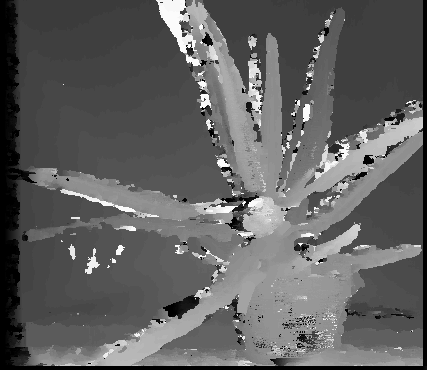

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

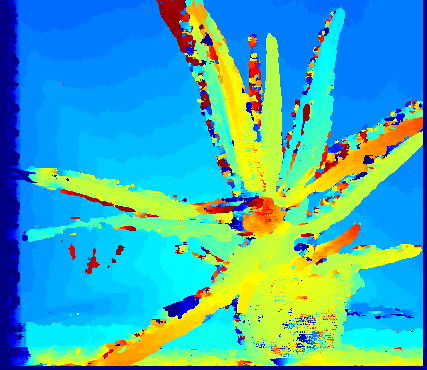

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)

# Solve the problem of 2 image with diference of brightness by Window-based medthod(Corelation Coefficient)

## Vectoried Function

In [ ]:
def compute_intergral_image(img):
  sum_axis_0 = np.cumsum(img, axis = 0)
  sum_axis_1 = np.cumsum(sum_axis_0, axis = 1)
  return sum_axis_1

In [ ]:
# function find disparity map with window-based matching vectorized
def window_based_matching_correlation_coefficient_vectoried(left_img_path, right_img_path, disparity_range = 16, kernel_size = 5, save_result = True):
  print("Compute disparity map using window_based matching with Correlation Coefficient")

  # read grascale left and right imgage with opencv, change it to numpy array with dytpe = float32
  left_img = cv2.imread(left_img_path, 0)
  right_img = cv2.imread(right_img_path, 0)
  left_img = np.asarray(left_img, dtype = np.float32)
  right_img = np.asarray(right_img, dtype = np.float32)
  # get height and width of left image
  left_height, left_width = left_img.shape

  # some variable
  kernel_half = int((kernel_size - 1) / 2)


  # find integral x,y, x^2 and y^2 from left and right image
  integral_x = compute_intergral_image(left_img)
  integral_y = compute_intergral_image(right_img)
  integral_xx = compute_intergral_image(left_img * left_img)
  integral_yy = compute_intergral_image(right_img * right_img)

  # find integral XY from left and right image
  integral_xy = np.full((left_height, left_width, disparity_range), 255, dtype = np.float32)
  for d in range(disparity_range):
    integral_xy[:, d : left_width, d] = left_img[:, d : left_width] * right_img[:, 0 : left_width - d]
    integral_xy[:, :, d] = compute_intergral_image(integral_xy[:, :, d])

  # compute sum of window
  
  integral_sum_xy = np.full((left_height, left_width, disparity_range), 255, dtype = np.float32)
  integral_sum_x = np.full((left_height, left_width), 255, dtype = np.float32)
  integral_sum_y = np.full((left_height, left_width), 255, dtype = np.float32)
  integral_sum_xx = np.full((left_height, left_width), 255, dtype = np.float32)
  integral_sum_yy = np.full((left_height, left_width), 255, dtype = np.float32)

  integral_sum_xy[: left_height - kernel_half , : left_width - kernel_half , :] = integral_xy[kernel_half :, kernel_half :, :]
  integral_sum_xy[kernel_half +1:, kernel_half +1:, :] += integral_xy[: left_height - kernel_half -1, : left_width - kernel_half -1, :]
  integral_sum_xy[kernel_half +1:, : left_width - kernel_half , :]  -= integral_xy[: left_height - kernel_half -1, kernel_half :, :]
  integral_sum_xy[: left_height - kernel_half , kernel_half +1:, :] -= integral_xy[kernel_half :, : left_width - kernel_half -1, :]

  integral_sum_x[: left_height - kernel_half , : left_width - kernel_half] = integral_x[kernel_half :, kernel_half :]
  integral_sum_x[kernel_half +1:, kernel_half +1:] += integral_x[: left_height - kernel_half -1, : left_width - kernel_half -1]
  integral_sum_x[kernel_half +1:, : left_width - kernel_half ] -= integral_x[: left_height - kernel_half -1, kernel_half :]
  integral_sum_x[: left_height - kernel_half , kernel_half +1: ] -= integral_x[kernel_half :, : left_width - kernel_half -1]

  integral_sum_xx[: left_height - kernel_half , : left_width - kernel_half] = integral_xx[kernel_half :, kernel_half :]
  integral_sum_xx[kernel_half +1:, kernel_half +1:] = integral_sum_xx[kernel_half +1:, kernel_half +1:] + integral_xx[: left_height - kernel_half -1, : left_width - kernel_half -1]
  integral_sum_xx[kernel_half +1:, : left_width - kernel_half ]  -= integral_xx[: left_height - kernel_half -1, kernel_half :]
  integral_sum_xx[: left_height - kernel_half , kernel_half +1: ] -= integral_xx[kernel_half :, : left_width - kernel_half -1]

  integral_sum_y[: left_height - kernel_half , : left_width - kernel_half ] = integral_y[kernel_half :, kernel_half :]
  integral_sum_y[kernel_half +1:, kernel_half +1: ] = integral_sum_y[kernel_half +1:, kernel_half +1: ] + integral_y[: left_height - kernel_half -1, : left_width - kernel_half -1]
  integral_sum_y[kernel_half +1:, : left_width - kernel_half ] -= integral_y[: left_height - kernel_half -1, kernel_half :]
  integral_sum_y[: left_height - kernel_half , kernel_half +1:] -= integral_y[kernel_half :, : left_width - kernel_half -1]

  integral_sum_yy[: left_height - kernel_half , : left_width - kernel_half ] = integral_yy[kernel_half :, kernel_half :]
  integral_sum_yy[kernel_half +1:, kernel_half +1: ] = integral_sum_yy[kernel_half +1:, kernel_half +1: ] + integral_yy[: left_height - kernel_half -1, : left_width - kernel_half -1]
  integral_sum_yy[kernel_half +1:, : left_width - kernel_half ]  -= integral_yy[: left_height - kernel_half -1, kernel_half :]
  integral_sum_yy[: left_height - kernel_half , kernel_half +1:] -= integral_yy[kernel_half :, : left_width - kernel_half -1]
  # compute cost space
  cost_space = np.full((left_height, left_width, disparity_range), -1.0, dtype = np.float32)
  n = kernel_size ** 2
  # compute cost space with cosine simmilarity
  for d in range(disparity_range):
    nor = (n * integral_sum_xy[:, d : left_width, d]) - (integral_sum_x[:, d : left_width] * integral_sum_y[:,  : left_width - d])
    denor = np.sqrt((n * integral_sum_xx[:, d : left_width]) - (integral_sum_x[:, d : left_width] ** 2)) * np.sqrt((n * integral_sum_yy[:, : left_width - d]) - (integral_sum_y[:,  : left_width - d] ** 2))
    cost_space[:, d : left_width, d] = nor / denor

  depth = np.argmax(cost_space, axis=2) * (255 / disparity_range)
  depth = depth.astype(np.uint8)

  # save the result
  if save_result:
    cv2.imwrite("Disparity_grascale.png", depth)
    cv2.imwrite("Disparity_color.png", cv2.applyColorMap(depth, cv2.COLORMAP_JET))
    print("Saving result ...")

  print("Done")
  return depth

In [ ]:
left_img_path = "Aloe/Aloe_left_1.png"
right_img_path = "Aloe/Aloe_right_2.png"

window_based_matching = window_based_matching_correlation_coefficient_vectoried(left_img_path, right_img_path, disparity_range = disparity_range, kernel_size = kernel_size, save_result = True)

Compute disparity map using window_based matching with Correlation Coefficient


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in sqrt


Saving result ...
Done


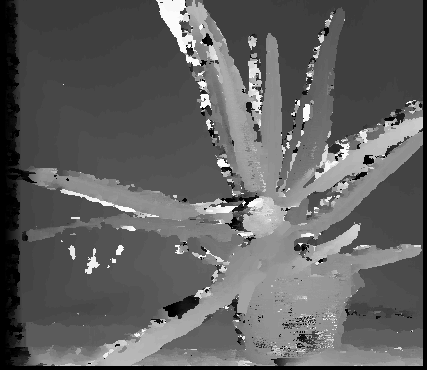

In [ ]:
gray_scale_img = cv2.imread("Disparity_grascale.png")
cv2_imshow(gray_scale_img)

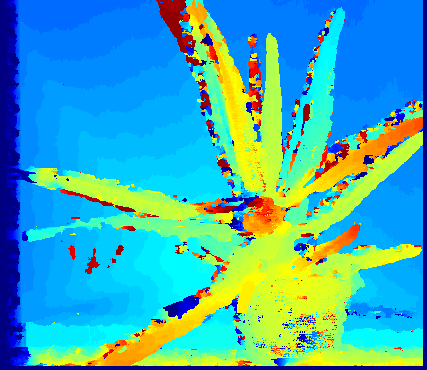

In [ ]:
color_map_img = cv2.imread("Disparity_color.png")
cv2_imshow(color_map_img)